In [13]:
import torch
import numpy as np

In [14]:
w = torch.tensor(2.8, requires_grad=True)
b = torch.tensor(1.0, requires_grad=True)

x = torch.tensor([1.0, 2.0])

In [15]:
y_pred = w * x + b
print(f"y_pred: {y_pred}")

y_pred: tensor([3.8000, 6.6000], grad_fn=<AddBackward0>)


In [16]:
y_true = torch.tensor([10.0, 10.0])
loss = ((y_true - y_pred) ** 2).mean()
print(f"loss: {loss.item()}")

loss: 25.0


In [17]:
print(f"w before backward: w.grad = {w.grad}")

w before backward: w.grad = None


In [18]:
loss.backward()


In [19]:
print(f"apres backward: w.grad = {w.grad}")
print(f"apres backward: b.grad = {b.grad}")

apres backward: w.grad = -13.0
apres backward: b.grad = -9.600000381469727


In [20]:
learning_rate = 0.01
with torch.no_grad():
    w -= learning_rate * w.grad
    b -= learning_rate * b.grad


In [21]:
print(f"nouveau poids: w = {w}, b = {b}")

nouveau poids: w = 2.929999828338623, b = 1.0959999561309814


In [22]:
import torch.nn as nn
perception = nn.Linear(1, 1)

print(f"poids: {perception.weight}")
print(f"biais: {perception.bias}")

poids: Parameter containing:
tensor([[-0.3755]], requires_grad=True)
biais: Parameter containing:
tensor([0.3238], requires_grad=True)


In [23]:
# Créer un tensor de la forme (batch_size, in_features)
# perception attend des entrées de forme (N, 1) car nn.Linear(1,1)
x = torch.tensor([[3.0]])  # batch de 2 échantillons, 1 feature chacun
print(f"input: {x}")
y_prod = perception(x)
print(y_prod)

input: tensor([[3.]])
tensor([[-0.8027]], grad_fn=<AddmmBackward0>)


In [24]:
y_true = torch.tensor([[10.0]])
criterium = nn.MSELoss()
loss = criterium(y_prod, y_true)
print(f"loss: {loss.item()}")

loss: 116.69892883300781


In [25]:
loss.backward()

In [26]:
print(f"gradient du poids: {perception.weight.grad}")
print(f"gradient du biais: {perception.bias.grad}")

gradient du poids: tensor([[-64.8164]])
gradient du biais: tensor([-21.6055])


In [27]:
import torch.optim as optim
optimizer = optim.SGD(perception.parameters(), lr=0.01)


In [28]:
optimizer.step()


In [29]:
print(f"nouveau poids : {perception.weight} {perception.bias}")

nouveau poids : Parameter containing:
tensor([[0.2727]], requires_grad=True) Parameter containing:
tensor([0.5399], requires_grad=True)


In [30]:
optimizer.zero_grad()

In [31]:
class SimpleNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 4)
        self.fc2 = nn.Linear(4, 3)
        self.fc3 = nn.Linear(3, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

In [32]:
model = SimpleNet()

In [34]:
# Entrée : un batch d'un seul échantillon avec 2 features (SimpleNet attend 2 features)
x = torch.tensor([[1.0, 2.0]])  # forme (1, 2)
y = torch.tensor([[5.0]])  # forme (1, 1)
y_pred = model(x)
print(y_pred)

tensor([[0.4352]], grad_fn=<SigmoidBackward0>)


In [35]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Normalize, Compose
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter

In [59]:
transform = Compose([
    ToTensor(),
    Normalize((0.1307,), (0.3081,))
])

training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=transform
)
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=transform
)


In [37]:
training_dataloader = DataLoader(training_data, batch_size=64, shuffle=True, pin_memory=True, num_workers=4)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=False, pin_memory=True, num_workers=4)

In [38]:
print(training_data.classes)
print(training_data.data.size())

['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']
torch.Size([60000, 28, 28])


In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.fc = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.fc(x)
        return logits


In [60]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
model = NeuralNetwork().to(device)

In [45]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [46]:
writer = SummaryWriter('runs/mnist_training')

def train(dataloader, model, loss_fn, optimizer, epoch):
    size = len(dataloader.dataset)
    model.train()
    total_loss = 0.0
    for batch_idx, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        pred = model(X)
        loss = loss_fn(pred, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += loss.item()
        if batch_idx % 100 == 0:
            loss_value = loss.item()
            current = (batch_idx + 1) * len(X)
            print(f"loss: {loss_value:>7f}  [{current:>5d}/{size:>5d}]")
            writer.add_scalar('Loss/train', loss_value, epoch * len(dataloader) + batch_idx)

    avg_loss = total_loss / len(dataloader)
    writer.add_scalar('Loss/train_epoch', avg_loss, epoch)


In [47]:
def test(dataloader, model, loss_fn, epoch):
    if isinstance(dataloader, torch.utils.data.Dataset):
        dataloader = DataLoader(dataloader, batch_size=64)

    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0.0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    accuracy = 100.0 * correct / size
    print(f"Test set: Accuracy: {accuracy:0.1f}%, Avg loss: {test_loss:>8f}")
    
    writer.add_scalar('Loss/test', test_loss, epoch)
    writer.add_scalar('Accuracy/test', accuracy, epoch)


In [61]:
epoche = 10
for t in range(epoche):
    print(f"epoche {t+1}\n-------------------------------")
    train(training_dataloader, model, loss_fn, optimizer, t)
    test(test_data, model, loss_fn, t)

writer.close()
print("Done!")


epoche 1
-------------------------------
loss: 2.306140  [   64/60000]
loss: 2.306140  [   64/60000]
loss: 2.320971  [ 6464/60000]
loss: 2.320971  [ 6464/60000]
loss: 2.299444  [12864/60000]
loss: 2.299444  [12864/60000]
loss: 2.307637  [19264/60000]
loss: 2.307637  [19264/60000]
loss: 2.307882  [25664/60000]
loss: 2.307882  [25664/60000]
loss: 2.323868  [32064/60000]
loss: 2.323868  [32064/60000]
loss: 2.309879  [38464/60000]
loss: 2.309879  [38464/60000]
loss: 2.322289  [44864/60000]
loss: 2.322289  [44864/60000]
loss: 2.315463  [51264/60000]
loss: 2.315463  [51264/60000]
loss: 2.292439  [57664/60000]
loss: 2.292439  [57664/60000]
Test set: Accuracy: 11.7%, Avg loss: 2.310384
epoche 2
-------------------------------
Test set: Accuracy: 11.7%, Avg loss: 2.310384
epoche 2
-------------------------------
loss: 2.299320  [   64/60000]
loss: 2.299320  [   64/60000]
loss: 2.303643  [ 6464/60000]
loss: 2.303643  [ 6464/60000]
loss: 2.315146  [12864/60000]
loss: 2.315146  [12864/60000]
loss:

In [49]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class ImageClassifierModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [50]:
torch_model = ImageClassifierModel()
# Create example inputs for exporting the model. The inputs should be a tuple of tensors.
example_inputs = (torch.randn(1, 1, 32, 32),)
onnx_program = torch.onnx.export(torch_model, example_inputs, dynamo=True)

[torch.onnx] Obtain model graph for `ImageClassifierModel([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `ImageClassifierModel([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Obtain model graph for `ImageClassifierModel([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅


In [51]:
onnx_program.save("image_classifier_model.onnx")

In [52]:
import onnx

onnx_model = onnx.load("image_classifier_model.onnx")
onnx.checker.check_model(onnx_model)

In [ ]:
class ConvolutionalNeuralNetwork(nn.Module):
    def __init__(self):
        super(ConvolutionalNeuralNetwork, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.dropout(x)
        x = self.pool(self.relu(self.conv2(x)))
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

cnn_model = ConvolutionalNeuralNetwork().to(device)


ConvolutionalNeuralNetwork(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)


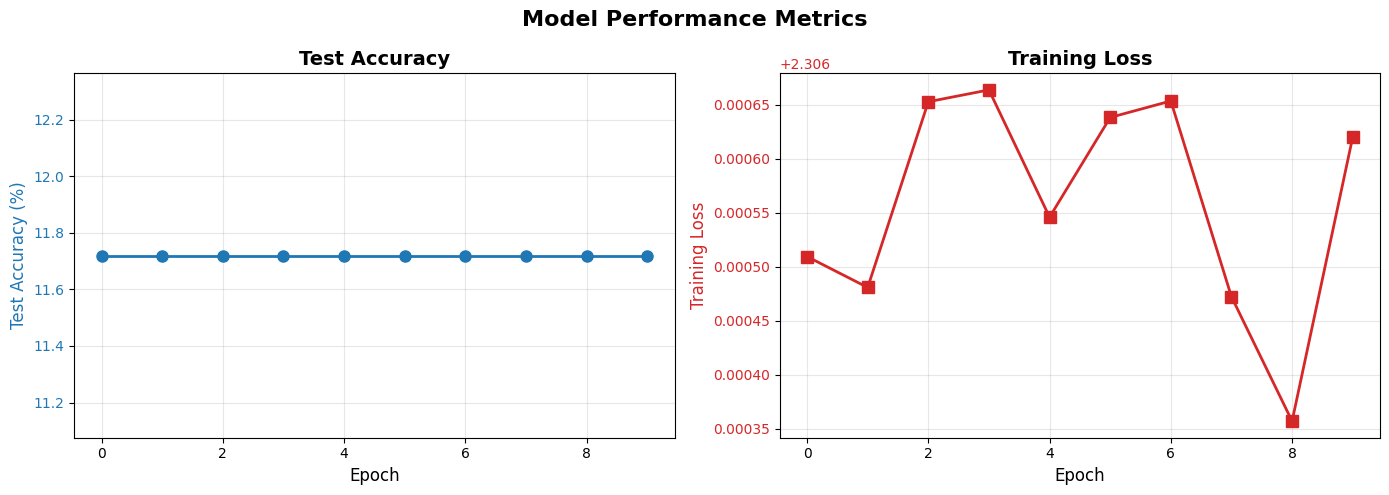

In [62]:
from tensorboard.backend.event_processing import event_accumulator
import os

event_path = 'runs/mnist_training'
ea = event_accumulator.EventAccumulator(event_path)
ea.Reload()

train_losses = [scalar.value for scalar in ea.Scalars('Loss/train_epoch')]
test_accuracies = [scalar.value for scalar in ea.Scalars('Accuracy/test')]

epochs = list(range(len(train_losses)))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(epochs, test_accuracies, color='tab:blue', marker='o', linewidth=2, markersize=8)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Test Accuracy (%)', color='tab:blue', fontsize=12)
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.grid(True, alpha=0.3)
ax1.set_title('Test Accuracy', fontsize=14, fontweight='bold')

ax2.plot(epochs, train_losses, color='tab:red', marker='s', linewidth=2, markersize=8)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Training Loss', color='tab:red', fontsize=12)
ax2.tick_params(axis='y', labelcolor='tab:red')
ax2.grid(True, alpha=0.3)
ax2.set_title('Training Loss', fontsize=14, fontweight='bold')

fig.suptitle('Model Performance Metrics', fontsize=16, fontweight='bold')
fig.tight_layout()
plt.show()


In [ ]:
import tensorflowjs as tfjs

model_path = 'model_tfjs'
tfjs.converters.save_keras_model(model, model_path)
print(f"Modèle sauvegardé dans {model_path}")
